In [1]:
# load packages
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import geopandas as gpd
import contextily as cx
import matplotlib
import warnings
from  matplotlib.ticker import PercentFormatter
from shapely.geometry import LineString

warnings.filterwarnings("ignore")

#work directory is where the I-O data are stored
work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ'
os.chdir(work_dir)

In [2]:
# load census tract file
state = 'CA'
census_tract_gdf = gpd.read_file('data/Network/' + state + '/CA_census_tracts_2010_clean.geojson')
census_tract_df = pd.DataFrame(census_tract_gdf.drop(columns='geometry'))
census_tract_gdf.loc[:, 'GEOID'] = census_tract_gdf.loc[:, 'GEOID'].astype(int)
od_trip_file = 'NHTS_car_trips_CA.csv'
NHTS_OD_trips = read_csv('data/Network/' + state + '/' + od_trip_file, low_memory=False)

ccst_lookup_file = 'ccst_geoid_key_tranps_geo_with_imputation.csv'
ccst_lookup = read_csv('data/' + ccst_lookup_file, sep = ',')

# census_tract_gdf.head(5)
census_tract_gdf = census_tract_gdf.set_index('GEOID')
centroids = census_tract_gdf.centroid
centroids = gpd.GeoSeries(centroids, name='centroids')
centroids.head(5)

GEOID
6001425103    POINT (-122.28986 37.84258)
6001425104    POINT (-122.28341 37.83264)
6001426100    POINT (-122.22539 37.82162)
6001427100    POINT (-122.23122 37.76464)
6001427800    POINT (-122.26905 37.77147)
Name: centroids, dtype: geometry

In [3]:
NHTS_OD_trips['trip_indx'] = NHTS_OD_trips.reset_index().index + 1
output_attrs = ['trip_indx', 'o_geoid', 'd_geoid', 'trpmiles', 'wtperfin']
cut_off = NHTS_OD_trips['trpmiles'].quantile(0.99)
NHTS_OD_trips = NHTS_OD_trips[output_attrs]
NHTS_OD_trips = NHTS_OD_trips.loc[NHTS_OD_trips['trpmiles'] <= cut_off]
NHTS_OD_trips = NHTS_OD_trips.dropna()
NHTS_OD_trips[['o_geoid', 'd_geoid']] = NHTS_OD_trips[['o_geoid', 'd_geoid']].astype(int)
NHTS_OD_trips.head(5)

,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin
0,1,6111000902,6037123103,68.406,892.495773
1,2,6037123103,6111000902,73.720,892.495773
2,3,6111000902,6037195202,77.937,752.790601
3,4,6037195202,6111000902,77.821,752.790601
4,5,6007000901,6007001400,8.050,184.981624


In [4]:
available_census_tract = centroids.index.to_list()
NHTS_OD_trips = NHTS_OD_trips.loc[NHTS_OD_trips['o_geoid'].isin(available_census_tract)]
NHTS_OD_trips = NHTS_OD_trips.loc[NHTS_OD_trips['d_geoid'].isin(available_census_tract)]

NHTS_OD_trips.loc[:, 'o_point'] = NHTS_OD_trips.apply(lambda row : centroids.loc[row['o_geoid']], axis = 1)
NHTS_OD_trips.loc[:, 'd_point'] = NHTS_OD_trips.apply(lambda row : centroids.loc[row['d_geoid']], axis = 1)
NHTS_OD_trips.head(5)

,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin,o_point,d_point
0,1,6111000902,6037123103,68.406,892.495773,POINT (-119.2139644258922 34.42160189052127),POINT (-118.3654642433344 34.19086998780995)
1,2,6037123103,6111000902,73.720,892.495773,POINT (-118.3654642433344 34.19086998780995),POINT (-119.2139644258922 34.42160189052127)
2,3,6111000902,6037195202,77.937,752.790601,POINT (-119.2139644258922 34.42160189052127),POINT (-118.2786417281254 34.10302416722837)
3,4,6037195202,6111000902,77.821,752.790601,POINT (-118.2786417281254 34.10302416722837),POINT (-119.2139644258922 34.42160189052127)
4,5,6007000901,6007001400,8.050,184.981624,POINT (-121.762762227355 39.71811346003699),POINT (-121.9461200836371 39.78130031848363)


In [5]:
def get_line(x, y):
    try:
        # Floor Division : Gives only Fractional
        # Part as Answer
        result = LineString([x, y])
#         print(result)
    except IndexError:
        result = np.nan
    return(result)
# sample_centroids_pair.to_csv('data/tract_centroid_troubleshoot.csv')
# centroids_pair = centroids_pair.loc[centroids_pair['o_point'] != 'POINT EMPTY']
# centroids_pair = centroids_pair.loc[centroids_pair['d_point'] != 'POINT EMPTY']
# for row in sample_centroids_pair.iterrows():
#     print(row)
#     LineString([row['o_point'], row['d_point']])
NHTS_OD_trips.loc[:, 'line'] = \
NHTS_OD_trips.apply(lambda row: get_line(row['o_point'], row['d_point']), axis=1)
NHTS_OD_trips = NHTS_OD_trips.dropna()
print(len(NHTS_OD_trips))
NHTS_OD_trips.head(5)


150705


,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin,o_point,d_point,line
0,1,6111000902,6037123103,68.406,892.495773,POINT (-119.2139644258922 34.42160189052127),POINT (-118.3654642433344 34.19086998780995),LINESTRING (-119.2139644258922 34.421601890521...
1,2,6037123103,6111000902,73.720,892.495773,POINT (-118.3654642433344 34.19086998780995),POINT (-119.2139644258922 34.42160189052127),LINESTRING (-118.3654642433344 34.190869987809...
2,3,6111000902,6037195202,77.937,752.790601,POINT (-119.2139644258922 34.42160189052127),POINT (-118.2786417281254 34.10302416722837),LINESTRING (-119.2139644258922 34.421601890521...
3,4,6037195202,6111000902,77.821,752.790601,POINT (-118.2786417281254 34.10302416722837),POINT (-119.2139644258922 34.42160189052127),LINESTRING (-118.2786417281254 34.103024167228...
4,5,6007000901,6007001400,8.050,184.981624,POINT (-121.762762227355 39.71811346003699),POINT (-121.9461200836371 39.78130031848363),LINESTRING (-121.762762227355 39.7181134600369...


In [6]:
NHTS_OD_trips_gdf = gpd.GeoDataFrame(NHTS_OD_trips, 
                                 crs="EPSG:4326", geometry= 'line')
NHTS_OD_trips_gdf = NHTS_OD_trips_gdf[['trip_indx', 'o_geoid', 'd_geoid', 'trpmiles', 
                                         'wtperfin', 'line']]

In [7]:
sample_route = NHTS_OD_trips_gdf.head(10000)
sample_route = sample_route[['trip_indx', 'o_geoid', 'd_geoid', 'line']]
sample_route.to_file("data/sample_route.geojson", driver='GeoJSON')

In [35]:
census_tract_gdf = census_tract_gdf.reset_index()
NHTS_OD_trips_by_tract = gpd.overlay(NHTS_OD_trips_gdf, census_tract_gdf, 
                                     how='intersection')

NHTS_OD_trips_by_tract.head(5)

,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin,index,GEOID,NAME,geometry
0,1,6111000902,6037123103,68.406,892.495773,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (-118.61184 34.25787, -118.60948 34..."
1,2,6037123103,6111000902,73.720,892.495773,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (-118.60948 34.25722, -118.61184 34..."
2,4375,6037113211,6037113301,4.429,1296.717356,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (-118.60731 34.26300, -118.59655 34..."
3,10677,6037231220,6111008402,39.849,1682.349381,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (-118.60025 34.25723, -118.60744 34..."
4,10686,6037231220,6111008402,39.849,1652.486082,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (-118.60025 34.25723, -118.60744 34..."


In [36]:
NHTS_OD_trips_by_tract = NHTS_OD_trips_by_tract.to_crs("EPSG:3310") # meter projection
NHTS_OD_trips_by_tract.loc[:, 'thru_length'] = NHTS_OD_trips_by_tract.loc[:, 'geometry'].length
NHTS_OD_trips_by_tract.loc[:, 'thru_length'].head(5)

0     229.184496
1     229.184496
2    1092.965251
3     909.216610
4     909.216610
Name: thru_length, dtype: float64

In [37]:
print(ccst_lookup.columns)
ccst_lookup_short = ccst_lookup[['GEOID', 'FID', 'MicrotypeID']]  
ccst_lookup_short.loc[:, 'GEOID'] = ccst_lookup_short.loc[:, 'GEOID'].astype(int)
NHTS_OD_trips_by_tract = pd.merge(NHTS_OD_trips_by_tract, ccst_lookup_short, 
                             on = 'GEOID', how = 'left')

NHTS_OD_trips_by_tract.loc[:, 'thru_length_ccst'] = \
NHTS_OD_trips_by_tract.groupby(['trip_indx', 'FID'])['thru_length'].transform('sum')

NHTS_OD_trips_by_tract.head(5)

Index(['FID', 'GEOID', 'MicrotypeID', 'microtype', 'microtype_imp', 'fips_st',
       'st_code', 'state', 'cty', 'ctyname', 'cbsa', 'cbsaname', 'spatial_id',
       'geotype', 'geotype_imp'],
      dtype='object')


,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin,index,GEOID,NAME,geometry,thru_length,FID,MicrotypeID,thru_length_ccst
0,1,6111000902,6037123103,68.406,892.495773,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (127821.002 -416623.861, 128039.816...",229.184496,1009.0,A_2,13011.206154
1,2,6037123103,6111000902,73.720,892.495773,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (128039.816 -416692.022, 127821.002...",229.184496,1009.0,A_2,13011.206154
2,4375,6037113211,6037113301,4.429,1296.717356,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (128230.036 -416048.840, 129227.585...",1092.965251,1009.0,A_2,4974.882725
3,10677,6037231220,6111008402,39.849,1682.349381,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (128889.835 -416678.686, 128218.448...",909.216610,1009.0,A_2,9204.737310
4,10686,6037231220,6111008402,39.849,1652.486082,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (128889.835 -416678.686, 128218.448...",909.216610,1009.0,A_2,9204.737310


,trip_indx,o_geoid,d_geoid,trpmiles,wtperfin,index,GEOID,NAME,geometry,thru_length,FID,MicrotypeID,thru_length_ccst
0,1,6111000902,6037123103,68.406,892.495773,169,6037113212,"Census Tract 1132.12, Los Angeles County, Cali...","LINESTRING (127821.002 -416623.861, 128039.816...",229.184496,1009.0,A_2,13011.206154
34,1,6111000902,6037123103,68.406,892.495773,171,6037113301,"Census Tract 1133.01, Los Angeles County, Cali...","LINESTRING (132229.625 -417995.878, 133213.279...",1030.079378,1009.0,A_2,13011.206154
101,1,6111000902,6037123103,68.406,892.495773,172,6037113321,"Census Tract 1133.21, Los Angeles County, Cali...","LINESTRING (129062.254 -417010.425, 130380.496...",1380.622111,1009.0,A_2,13011.206154
130,1,6111000902,6037123103,68.406,892.495773,173,6037115101,"Census Tract 1151.01, Los Angeles County, Cali...","LINESTRING (136319.944 -419266.435, 137813.392...",1563.668872,1009.0,A_2,13011.206154


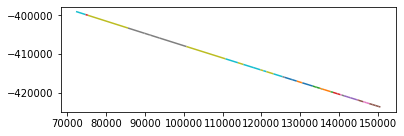

In [39]:
# plot sample
sample_result = NHTS_OD_trips_by_tract.loc[NHTS_OD_trips_by_tract['trip_indx'] == 1]
# print(sample_result.head(5))
# sample_result.loc[:, 'thru_length'] = sample_result.loc[:, 'geometry'].length
sample_result.plot(column='NAME')
sample_result.head(4)

In [41]:
NHTS_OD_trips_by_tract_df = pd.DataFrame(NHTS_OD_trips_by_tract)
NHTS_OD_trips_by_tract_df = NHTS_OD_trips_by_tract_df[['trip_indx',	'o_geoid', 'd_geoid', 'trpmiles',
                                                       'wtperfin',	'GEOID', 'FID',	'MicrotypeID',
                                                       'thru_length', 'thru_length_ccst']] 

NHTS_OD_trips_by_tract_df.to_csv('data/Network/' + state + '/' + 'NHTS_OD_desire_line_by_tract.csv', index = False)

In [3]:
# create grid of points
# census_tract_df = census_tract_df.reset_index()
geoid = census_tract_df['GEOID']
geoid = geoid.to_frame()
centroids_pair = geoid.merge(geoid, how="cross") 
print(len(centroids_pair))



64915249


,o_GEOID,d_GEOID
0,06001425103,06001425103
1,06001425103,06001425104
2,06001425103,06001426100
3,06001425103,06001427100
4,06001425103,06001427800
